In [160]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('../nonlin')
sys.path.append('../partion')
sys.path.append('../1D-difusion')

from aspen import aspen
from newton import newton

import partion
import wrapper

from one_phase import one_phase
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
# some polynomial func
class nonlinear_func():
    def __init__(self, N_dim, N_deg):
        self.A = np.zeros((N_dim, N_dim, N_deg))
        self.N = N_dim
        self.N_deg = N_deg
        self.Jx = np.zeros((N_dim, N_dim))
        self.gb_Jx = np.zeros((N_dim, N_dim))
    def set_coef(self, deg, A):
        self.A[:, : , deg] = A
    def val(self, u, st = 0, end = None):
        if end == None:
            end = self.N
        ret = np.zeros((end-st, 1))
        for k in range(0, self.N_deg, 1):
            ret += self.A[st:end, :, k] @ u**k        
        return ret
    def jac(self, u, st = 0, end = None):
        if end == None:
            end = self.N
        self.Jx[st:end, st:end] = np.zeros((end-st, end-st))
        for k in range(1, self.N_deg, 1):
            self.Jx[st:end, st:end] += self.A[st:end, st:end, k] \
                @ np.diag(k * u[st:end].flatten()**(k-1))
        return self.Jx[st:end, st:end]
    def sec_jac(self, u):
        Jxx = np.zeros((self.N, self.N))
        for k in range(2, self.N_deg, 1):
            Jxx += self.A[:, :, k] \
                @ np.diag(k*(k-1) * u.flatten()**(k-2))
        return Jxx
    def jac_gb(self, u, domain_borders):
        self.gb_Jx = np.copy(self.Jx)

        for i in range(domain_borders.shape[0]-1):
            st = domain_borders[i]
            end = domain_borders[i+1]
            for k in range(1, self.N_deg, 1):
                self.gb_Jx[st:end, end:] += \
                    self.A[st:end, end:, k] @ np.diag(k * u[end:].flatten()**(k-1))
                self.gb_Jx[end:, st:end] += \
                    self.A[end:, st:end, k] @ np.diag(k * u[st:end].flatten()**(k-1))
            
        return self.gb_Jx, self.Jx
        

In [174]:
N = 200

# let's build a problem form domains
f = nonlinear_func(N, 4)

A = np.eye(10)+0.5*np.diag(np.ones(9), k = 1) + 0.25*np.diag(np.ones(8), k = 2) \
    + 0.175*np.diag(np.ones(7), k = 3) + 0.0875*np.diag(np.ones(6), k = 4)

C = np.diag(np.ones(N-1), k = -1) + 0.5*np.diag(np.ones(N-2), k = -2) \
    + 0.5*np.diag(np.ones(N-3), k = -3) + 0.25*np.diag(np.ones(N-4), k = -4) \
    + 0.25*np.diag(np.ones(N-5), k = -5)

# by controlling s_i we contorl number of iterations
s1 = - 120*np.linspace(1, 10, N//5+30)
s2 = - 20*np.linspace(1, 10, N//5-30)
s3 = 2*np.linspace(10, 1.5, N//5)
s4 = 2*np.linspace(10, 1.5, N//5)
s5 = 2*np.linspace(10, 1.5, N//5)

B =  - np.diag(np.concatenate((s1, s2, s3, s4, s5)))

f.set_coef(0, B)
A3 = np.kron(np.eye(N//10,dtype=int),A)

f.set_coef(3, A3)
f.set_coef(1, -0.2*C)

In [175]:
from time import time

In [176]:
solver_cl = newton(1e-1)
solver_cl.init_func(f)
t = 0
for k in range(5):
    x0 = np.sign(np.arange(200)-100, dtype='float').reshape(-1, 1)
    t -= time()
    X_cl, code = solver_cl.solve(x0)
    t += time()
t /= 5
print(code, t)

True 0.3355409622192383


In [177]:
Nd = 5
part = partion.partion_equally(N, Nd)

solver_as= aspen(Nd, part, 1e-1, max_gb = 6, max_lc = 160)
solver_as.init_func(f)
solver_as.init_log()
t = 0
for k in range(5):
    x0 = np.sign(np.arange(200)-100, dtype='float').reshape(-1, 1)
    t -= time()
    X, mes = solver_as.solve(x0)
    t += time()
t /= 5
print(mes, t)

True 0.035131406784057614


[50. 55. 50. 20. 20.]


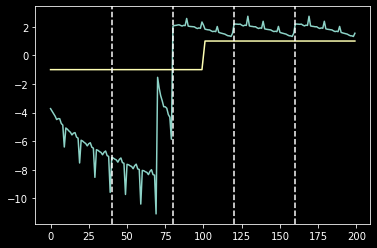

In [178]:
plt.plot(X)
plt.style.use('dark_background')
plt.plot(np.sign(np.arange(200)-100, dtype='float').reshape(-1, 1))
for bd in part[1:-1]:
    plt.axvline(bd, linestyle='--')
print(solver_as.lc_iters)

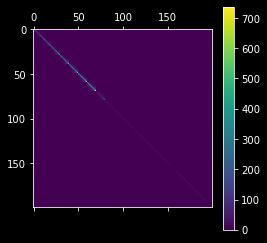

In [180]:
W = np.abs(f.jac(x0))
W = np.abs(W)
W = (W+W.T)

cs = plt.matshow(W)
plt.colorbar(cs)
plt.show()

[  0  40  80 130 170 200]


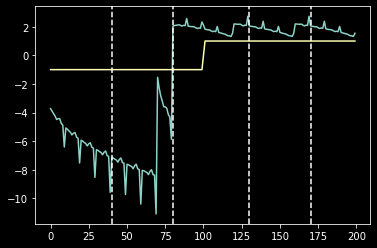

In [181]:
Nd = 5
borders = partion.domain_builder2(W, Nd, k = Nd+2)
print(borders)

plt.plot(X)
plt.style.use('dark_background')
plt.plot(np.sign(np.arange(200)-100, dtype='float').reshape(-1, 1))
for bd in borders[1:-1]:
    plt.axvline(bd, linestyle='--')

In [182]:
Nd = 5
solver_as = aspen(Nd, borders, 1e-1, max_gb = 6, max_lc = 20)
solver_as.init_func(f)
solver_as.init_log()
t = 0
for k in range(5):
    t -= time()
    x0 = np.sign(np.arange(200)-100, dtype='float').reshape(-1, 1)
    X, message = solver_as.solve(x0)
    t += time()
t /= 5
print(message, t)

True 0.030772304534912108


In [183]:
print(solver_as.lc_iters)

[50. 55. 50. 20. 20.]


In [184]:
bd_arr = []
t_arr = []
Nd = 5
for k in range(60):
    borders = partion.generate_random(N, Nd)
    t -= time()
    x0 = np.sign(np.arange(200)-100, dtype='float').reshape(-1, 1)
    solver_as = aspen(Nd, borders, 1e-1, max_gb = 6, max_lc = 20)
    solver_as.init_func(f)
    solver_as.init_log()
    X, message = solver_as.solve(x0)
    t += time()
    if message == 'OK':
        t_arr.append(t)
        bd_arr.append(t)
        
bd_arr = np.array(bd_arr)
t_arr = np.array(bd_arr)

In [185]:
print(bd_arr)

[]
